# DC1 Level 2 Database Access

The DC1 Level 2 object catalogs (comprising the deepCoadd results tables) have been loaded into a MySQL database at NERSC.  This notebook shows how to connect to the database and how to access the data.

The Level 2 pipeline output will be available at NERSC for three different DC1 simulations:

| Simulation | Disk location |
|------------|---------------|
| imSim undithered | `/global/cscratch1/sd/descdm/DC1/full_focalplane_undithered` | 
| imSim dithered   | `/global/cscratch1/sd/descdm/DC1/DC1-imsim-dithered` |
| phoSim dithered  | `/global/cscratch1/sd/descdm/DC1/DC1-phoSim-3a` (pending) |

The results from the two imSim runs have been ingested into the `DESC_DC1_Level_2` database


## Connecting via the MySQL command line

The most direct way to connect is to use the MySQL command line, and the easiest way set up the access credentials is with a MySQL option file.  For running at NERSC from a cori machine, the file would look like
```
$ cat ~/.my.cnf
[client]
host=nerscdb04.nersc.gov
database=DESC_DC1_Level_2
user=DESC_DC1_Level_2_user
password=<read_only_password>
```
Alternatively, one could ssh-tunnel from a remote machine to a cori with
```
ssh -L 3307:nerscdb04.nersc.gov:3306 <userid>@cori.nersc.gov
```
and the `~/.my.cnf` on the remote machine would contain
```
[client]
host="127.0.0.1"
port=3307
database=DESC_DC1_Level_2_user
password=<read_only_password>
```
In either case, one can just run `mysql` and get the command line prompt:
```
[cori10] mysql
MySQL [DESC_DC1_Level_2]> show tables;
+----------------------------+
| Tables_in_DESC_DC1_Level_2 |
+----------------------------+
| CcdVisit                   |
| Coadd_Object               |
| Project                    |
+----------------------------+
3 rows in set (0.00 sec)

MySQL [DESC_DC1_Level_2]> select * from Project;
+-----------+----------------------+
| projectId | projectName          |
+-----------+----------------------+
|         0 | DC1 imsim undithered |
|         1 | DC1 imsim dithered   |
+-----------+----------------------+
2 rows in set (0.01 sec)

```

## Connecting from Python via the pserv package

There are several options for connecting to a MySQL database from python.  The DESC [pserv](https://github.com/LSSTDESC/pserv) package uses `sqlalchemy` on the backend and the `lsst.daf.persistence.DbAuth` package from the LSST Stack as the mechanism for providing database credentials.  The `lsst_sims` code uses the same mechanism for connecting to the CatSim database hosted at UW.

To use `pserv` to connect, one needs a `~/.lsst/db-auth.paf` file:
```
$ cat ~/.lsst/db-auth.paf
database: {
    authInfo: {
        host: ki-sr01.slac.stanford.edu
        port: 3307
        user: jchiang
        password: <password>
    }
    authInfo: {
        host: "127.0.0.1"
        port: 33071
        user: jchiang
        password: <password>
    }
    authInfo: {
#        host: nerscdb04.nersc.gov
        host: "127.0.0.1"
        port: 3307
        user: DESC_DC1_Level_2_user
        password: <password>
    }
    authInfo: {
#        host: scidb1.nersc.gov
        host: "127.0.0.1"
        port: 3308
        user: desc_user
        password: <password>
    }
}
```
One can have different sets of credentials in this file, specified by host and port, both for direct and ssh-tunnel connections.  More info on using `DbAuth`, especially for connecting to the UW CatSim db, is available [here](https://confluence.lsstcorp.org/display/SIM/Accessing+the+UW+CATSIM+Database).  Instructions on installing `pserv` are available [here](https://github.com/LSSTDESC/pserv/blob/master/doc/Usage.md).

The examples below show how to use `pserv`.

In [1]:
import matplotlib.pyplot as plt
import desc.pserv
%matplotlib inline

In [2]:
conn = desc.pserv.DbConnection(host='127.0.0.1', port=3307, database='DESC_DC1_Level_2')

In [3]:
# The results from any query can be retrieved as a pandas DataFrame.
# This query uses constraints on raftName and ccdName to pick out the central sensor in order
# to get unique info for each visit.
query = "select * from CcdVisit where raftName='2,2' and ccdName='1,1' and projectId=0"
ccdVisit = conn.get_pandas_data_frame(query)
print len(ccdVisit)
print ccdVisit[:5]

807
    ccdVisitId  visitId ccdName raftName filterName nExposures    ra  decl  \
0  22110040337    40337     1,1      2,2          r       None  None  None   
1  22110040338    40338     1,1      2,2          r       None  None  None   
2  22110040367    40367     1,1      2,2          r       None  None  None   
3  22110040368    40368     1,1      2,2          r       None  None  None   
4  22110193157   193157     1,1      2,2          r       None  None  None   

  zenithDistance  llcx    ...    ccdTemp  binX  binY   WCS     zeroPoint  \
0           None  None    ...       None  None  None  None  5.312820e+12   
1           None  None    ...       None  None  None  None  5.248950e+12   
2           None  None    ...       None  None  None  None  5.190330e+12   
3           None  None    ...       None  None  None  None  5.198230e+12   
4           None  None    ...       None  None  None  None  5.145190e+12   

     seeing     skyBg skyNoise flags projectId  
0  0.712216   410.968

In [4]:
min(ccdVisit['seeing'].values),max(ccdVisit['seeing'].values)

(0.53849199999999997, 2.9910899999999998)

/u1/jchiang/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/u1/jchiang/miniconda/lib/python2.7/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


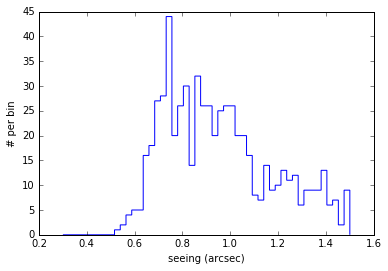

In [5]:
result = plt.hist(ccdVisit['seeing'].values, bins=50, histtype='step', range=(0.3, 1.5))
plt.xlabel('seeing (arcsec)')
plt.ylabel('# per bin')

In [6]:
query = '''select id, coord_ra, coord_dec, base_SdssCentroid_x, base_SdssCentroid_y, modelfit_CModel_flux,
           modelfit_CModel_fluxSigma, base_PsfFlux_flux, base_PsfFlux_fluxSigma,
           base_ClassificationExtendedness_value
           from Coadd_Object where deblend_nChild=0 
           and base_ClassificationExtendedness_value is not null and projectId=0 limit 10000'''
coadd_data = conn.get_pandas_data_frame(query)

In [7]:
print coadd_data

                  id  coord_ra  coord_dec  base_SdssCentroid_x  \
0     26393647775745  1.714243  -0.531958         24077.911373   
1     26393647775750  1.714277  -0.531766         24055.880380   
2     26393647775756  1.714251  -0.531673         24067.897622   
3     26393647775758  1.714602  -0.531537         23877.530235   
4     26394721517570  1.714602  -0.531537         23877.530228   
5     26394721517574  1.714379  -0.531397         23993.848682   
6     26394721517576  1.714490  -0.531328         23933.156316   
7     26394721517578  1.714266  -0.531251         24051.309809   
8     26394721517579  1.714302  -0.531234         24031.976644   
9     26394721517580  1.714494  -0.531225         23928.877520   
10    26394721517581  1.714706  -0.531184         23814.859397   
11    26394721517582  1.714389  -0.531191         23984.561486   
12    26394721517583  1.714319  -0.531170         24021.364149   
13    26394721517584  1.714610  -0.531169         23866.033337   
14    2639

### The Coadd_Object table schema

This schema for the Coadd_Object table is derived directly from the columns in the Level 2 coadd results merged catalogs.

```
MySQL [DESC_DC1_Level_2]> describe Coadd_Object;
+-------------------------------------------+---------------------+------+-----+---------+-------+
| Field                                     | Type                | Null | Key | Default | Extra |
+-------------------------------------------+---------------------+------+-----+---------+-------+
| FLAGS1                                    | bigint(20) unsigned | YES  |     | NULL    |       |
| FLAGS2                                    | bigint(20) unsigned | YES  |     | NULL    |       |
| FLAGS3                                    | bigint(20) unsigned | YES  |     | NULL    |       |
| id                                        | bigint(20)          | NO   | PRI | NULL    |       |
| coord_ra                                  | double              | YES  |     | NULL    |       |
| coord_dec                                 | double              | YES  |     | NULL    |       |
| parent                                    | bigint(20)          | YES  |     | NULL    |       |
| deblend_nChild                            | int(11)             | YES  |     | NULL    |       |
| deblend_psfCenter_x                       | double              | YES  |     | NULL    |       |
| deblend_psfCenter_y                       | double              | YES  |     | NULL    |       |
| deblend_psfFlux                           | double              | YES  |     | NULL    |       |
| base_GaussianCentroid_x                   | double              | YES  |     | NULL    |       |
| base_GaussianCentroid_y                   | double              | YES  |     | NULL    |       |
| base_NaiveCentroid_x                      | double              | YES  |     | NULL    |       |
| base_NaiveCentroid_y                      | double              | YES  |     | NULL    |       |
| base_SdssCentroid_x                       | double              | YES  |     | NULL    |       |
| base_SdssCentroid_y                       | double              | YES  |     | NULL    |       |
| base_SdssCentroid_xSigma                  | float               | YES  |     | NULL    |       |
| base_SdssCentroid_ySigma                  | float               | YES  |     | NULL    |       |
| base_InputCount_value                     | int(11)             | YES  |     | NULL    |       |
| base_SdssShape_xx                         | double              | YES  |     | NULL    |       |
| base_SdssShape_yy                         | double              | YES  |     | NULL    |       |
| base_SdssShape_xy                         | double              | YES  |     | NULL    |       |
| base_SdssShape_xxSigma                    | float               | YES  |     | NULL    |       |
| base_SdssShape_yySigma                    | float               | YES  |     | NULL    |       |
| base_SdssShape_xySigma                    | float               | YES  |     | NULL    |       |
| base_SdssShape_x                          | double              | YES  |     | NULL    |       |
| base_SdssShape_y                          | double              | YES  |     | NULL    |       |
| base_SdssShape_flux                       | double              | YES  |     | NULL    |       |
| base_SdssShape_fluxSigma                  | double              | YES  |     | NULL    |       |
| base_SdssShape_psf_xx                     | double              | YES  |     | NULL    |       |
| base_SdssShape_psf_yy                     | double              | YES  |     | NULL    |       |
| base_SdssShape_psf_xy                     | double              | YES  |     | NULL    |       |
| base_SdssShape_flux_xx_Cov                | float               | YES  |     | NULL    |       |
| base_SdssShape_flux_yy_Cov                | float               | YES  |     | NULL    |       |
| base_SdssShape_flux_xy_Cov                | float               | YES  |     | NULL    |       |
| ext_shapeHSM_HsmPsfMoments_x              | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmPsfMoments_y              | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmPsfMoments_xx             | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmPsfMoments_yy             | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmPsfMoments_xy             | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmShapeRegauss_e1           | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmShapeRegauss_e2           | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmShapeRegauss_sigma        | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmShapeRegauss_resolution   | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmSourceMoments_x           | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmSourceMoments_y           | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmSourceMoments_xx          | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmSourceMoments_yy          | double              | YES  |     | NULL    |       |
| ext_shapeHSM_HsmSourceMoments_xy          | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_xx     | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_yy     | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_xy     | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_x      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_y      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_0      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_1      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_2      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_3      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_4      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_0_5      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_1_xx     | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_1_yy     | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_1_xy     | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_1_x      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_1_y      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_1_0      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_1_1      | double              | YES  |     | NULL    |       |
| modelfit_DoubleShapeletPsfApprox_1_2      | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_3_0_flux        | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_3_0_fluxSigma   | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_4_5_flux        | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_4_5_fluxSigma   | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_6_0_flux        | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_6_0_fluxSigma   | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_9_0_flux        | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_9_0_fluxSigma   | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_12_0_flux       | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_12_0_fluxSigma  | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_17_0_flux       | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_17_0_fluxSigma  | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_25_0_flux       | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_25_0_fluxSigma  | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_35_0_flux       | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_35_0_fluxSigma  | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_50_0_flux       | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_50_0_fluxSigma  | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_70_0_flux       | double              | YES  |     | NULL    |       |
| base_CircularApertureFlux_70_0_fluxSigma  | double              | YES  |     | NULL    |       |
| base_GaussianFlux_flux                    | double              | YES  |     | NULL    |       |
| base_GaussianFlux_fluxSigma               | double              | YES  |     | NULL    |       |
| base_PsfFlux_flux                         | double              | YES  |     | NULL    |       |
| base_PsfFlux_fluxSigma                    | double              | YES  |     | NULL    |       |
| base_Variance_value                       | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_flux              | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_fluxSigma         | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_flux_inner        | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_ellipse_xx        | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_ellipse_yy        | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_ellipse_xy        | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_objective         | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_nonlinear_0       | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_nonlinear_1       | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_nonlinear_2       | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_fixed_0           | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_fixed_1           | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_nIter             | int(11)             | YES  |     | NULL    |       |
| modelfit_CModel_initial_time              | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_flux                  | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_fluxSigma             | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_flux_inner            | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_ellipse_xx            | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_ellipse_yy            | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_ellipse_xy            | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_objective             | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_nonlinear_0           | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_nonlinear_1           | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_nonlinear_2           | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_fixed_0               | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_fixed_1               | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_nIter                 | int(11)             | YES  |     | NULL    |       |
| modelfit_CModel_exp_time                  | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_flux                  | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_fluxSigma             | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_flux_inner            | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_ellipse_xx            | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_ellipse_yy            | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_ellipse_xy            | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_objective             | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_nonlinear_0           | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_nonlinear_1           | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_nonlinear_2           | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_fixed_0               | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_fixed_1               | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_nIter                 | int(11)             | YES  |     | NULL    |       |
| modelfit_CModel_dev_time                  | double              | YES  |     | NULL    |       |
| modelfit_CModel_flux                      | double              | YES  |     | NULL    |       |
| modelfit_CModel_fluxSigma                 | double              | YES  |     | NULL    |       |
| modelfit_CModel_flux_inner                | double              | YES  |     | NULL    |       |
| modelfit_CModel_fracDev                   | double              | YES  |     | NULL    |       |
| modelfit_CModel_objective                 | double              | YES  |     | NULL    |       |
| modelfit_CModel_ellipse_xx                | double              | YES  |     | NULL    |       |
| modelfit_CModel_ellipse_yy                | double              | YES  |     | NULL    |       |
| modelfit_CModel_ellipse_xy                | double              | YES  |     | NULL    |       |
| modelfit_CModel_region_initial_ellipse_xx | double              | YES  |     | NULL    |       |
| modelfit_CModel_region_initial_ellipse_yy | double              | YES  |     | NULL    |       |
| modelfit_CModel_region_initial_ellipse_xy | double              | YES  |     | NULL    |       |
| modelfit_CModel_region_final_ellipse_xx   | double              | YES  |     | NULL    |       |
| modelfit_CModel_region_final_ellipse_yy   | double              | YES  |     | NULL    |       |
| modelfit_CModel_region_final_ellipse_xy   | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_apCorr                | double              | YES  |     | NULL    |       |
| modelfit_CModel_exp_apCorrSigma           | double              | YES  |     | NULL    |       |
| base_PsfFlux_apCorr                       | double              | YES  |     | NULL    |       |
| base_PsfFlux_apCorrSigma                  | double              | YES  |     | NULL    |       |
| modelfit_CModel_apCorr                    | double              | YES  |     | NULL    |       |
| modelfit_CModel_apCorrSigma               | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_apCorr            | double              | YES  |     | NULL    |       |
| modelfit_CModel_initial_apCorrSigma       | double              | YES  |     | NULL    |       |
| base_GaussianFlux_apCorr                  | double              | YES  |     | NULL    |       |
| base_GaussianFlux_apCorrSigma             | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_apCorr                | double              | YES  |     | NULL    |       |
| modelfit_CModel_dev_apCorrSigma           | double              | YES  |     | NULL    |       |
| base_ClassificationExtendedness_value     | double              | YES  |     | NULL    |       |
| footprint                                 | int(11)             | YES  |     | NULL    |       |
| projectId                                 | int(11)             | NO   | PRI | NULL    |       |
| patch                                     | char(20)            | NO   | PRI | NULL    |       |
+-------------------------------------------+---------------------+------+-----+---------+-------+
166 rows in set (0.01 sec)

```

### The CcdVisit table

This table implements the `CcdVisit` table in [baseline schema](https://lsst-web.ncsa.illinois.edu/schema/index.php?sVer=baseline).  It is (partially) filled with information from the `registry.sqlite3` used by the Level 2 pipeline and from the `calexp` information, which is accessed using the data butler.

```
MySQL [DESC_DC1_Level_2]> describe CcdVisit;
+----------------+------------+------+-----+---------+-------+
| Field          | Type       | Null | Key | Default | Extra |
+----------------+------------+------+-----+---------+-------+
| ccdVisitId     | bigint(20) | NO   | PRI | NULL    |       |
| visitId        | int(11)    | YES  |     | NULL    |       |
| ccdName        | char(3)    | YES  |     | NULL    |       |
| raftName       | char(3)    | YES  |     | NULL    |       |
| filterName     | char(1)    | YES  |     | NULL    |       |
| nExposures     | int(11)    | YES  |     | NULL    |       |
| ra             | double     | YES  |     | NULL    |       |
| decl           | double     | YES  |     | NULL    |       |
| zenithDistance | float      | YES  |     | NULL    |       |
| llcx           | int(11)    | YES  |     | NULL    |       |
| llcy           | int(11)    | YES  |     | NULL    |       |
| ulcx           | int(11)    | YES  |     | NULL    |       |
| ulcy           | int(11)    | YES  |     | NULL    |       |
| urcx           | int(11)    | YES  |     | NULL    |       |
| urcy           | int(11)    | YES  |     | NULL    |       |
| lrcx           | int(11)    | YES  |     | NULL    |       |
| lrcy           | int(11)    | YES  |     | NULL    |       |
| xSize          | int(11)    | YES  |     | NULL    |       |
| ySize          | int(11)    | YES  |     | NULL    |       |
| obsStart       | timestamp  | YES  |     | NULL    |       |
| expMidpt       | double     | YES  |     | NULL    |       |
| expTime        | double     | YES  |     | NULL    |       |
| darkTime       | double     | YES  |     | NULL    |       |
| ccdTemp        | float      | YES  |     | NULL    |       |
| binX           | int(11)    | YES  |     | NULL    |       |
| binY           | int(11)    | YES  |     | NULL    |       |
| WCS            | blob       | YES  |     | NULL    |       |
| zeroPoint      | float      | YES  |     | NULL    |       |
| seeing         | float      | YES  |     | NULL    |       |
| skyBg          | float      | YES  |     | NULL    |       |
| skyNoise       | float      | YES  |     | NULL    |       |
| flags          | int(11)    | YES  |     | NULL    |       |
| projectId      | int(11)    | NO   | PRI | NULL    |       |
+----------------+------------+------+-----+---------+-------+
33 rows in set (0.00 sec)

```